<a href="https://colab.research.google.com/github/OsEduIT/GVIS-Automatic-Classification-of-Cyberincidents-using-Machine-Learning/blob/main/Programa_02_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instalación de librerias

In [ ]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
#STOPWORDS = set(stopwords.words('english'))
from bs4 import BeautifulSoup
#import plotly.graph_objs as go
#import plotly.plotly as py
#import cufflinks
#from IPython.core.interactiveshell import InteractiveShell
#import plotly.figure_factory as ff
#InteractiveShell.ast_node_interactivity = 'all'
#from plotly.offline import iplot
#cufflinks.go_offline()
#cufflinks.set_config_file(world_readable=True, theme='pearl')
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [ ]:
#df_clean_final = df3[['desp_clean_final','INCIBE TAXONOMY']]  

In [ ]:
#df_clean_final.to_csv(r'/content/drive/My Drive/Colab Notebooks\export_dataframe.csv',index=False,header=True)

# Cargar el Corpus

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls "/content/drive/My Drive/Colab Notebooks"

'Copia de ClaseVectorizacionTextos.ipynb'
'Copia de clasificacion_multiclase.ipynb'
'Copia de Fine tuning RoBERTa - Unhealthy Comment Corpus - Tutorial'
'Copia de gpt2_finetune_classification.ipynb'
'Copia de metricas_clasificacion.ipynb'
'Copia de Programa_02_comparasión_final.ipynb'
'Copia de Web scraping de Google Maps con Python + Selenium'
 DATA.csv
 datos.csv
 DATOS-TC1-GVIS.xlsx
 DocumentosAcreditativosMeritosOscar_plazaU226
 GoogleNews-vectors-negative300.bin.gz
 Matplotlib.ipynb
 merged-cleaned1.csv
 merged_cleaned.csv
 PipelineLimpieza-Encoder-Clasificador.ipynb
'PRC DATA BREACH.xlsx'
'Prepocesado de Datos.ipynb'
 PrimeraPruebaConcepto.ipynb
 Programa_01.ipynb
 Programa_02_BERT.ipynb
'Programa_02_CNN (1).ipynb'
 Programa_02_CNN.ipynb
 Programa_02_comparasión.ipynb
 Programa_02_LSTM.ipynb
 TFM_01.ipynb
 Untitled0.ipynb
 web_scraping_01.ipynb


In [ ]:
df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/datos.csv")

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8918 entries, 0 to 8917
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   desp_clean_final  8901 non-null   object
 1   INCIBE TAXONOMY   8918 non-null   object
dtypes: object(2)
memory usage: 139.5+ KB


In [ ]:
df.head()

,desp_clean_final,INCIBE TAXONOMY
0,compani websit breach sometim around februari ...,HC
1,decemb 29 2011 theft laptop park car san franc...,DL
2,bdo contract rubio perform financi audit servi...,DL
3,februari 10 2012 dhi mortgag becam awar softwa...,HC
4,offic burglari new year eve 2011 result loss h...,DL


In [ ]:
print(len(df))

8918


In [ ]:
df1 = df.dropna(axis='index',how='any') 

In [ ]:
print(len(df))
print(len(df1))

8918
8901


In [ ]:
df1.head(10)

,desp_clean_final,INCIBE TAXONOMY
0,compani websit breach sometim around februari ...,HC
1,decemb 29 2011 theft laptop park car san franc...,DL
2,bdo contract rubio perform financi audit servi...,DL
3,februari 10 2012 dhi mortgag becam awar softwa...,HC
4,offic burglari new year eve 2011 result loss h...,DL
5,rjl insur servic becam awar vulner comput netw...,DOI
6,someon purchas hard drive septemb 2011 immedi ...,DOI
7,secur compani search web sensit data uncov per...,DOI
8,hacker abl access name mail address email addr...,HC
9,storeroom window saint joseph healthcar clinic...,THEFT


In [ ]:
labels = sorted(df1['INCIBE TAXONOMY'].unique())
labels

['DL', 'DOI', 'HC', 'OTHERS', 'PAC', 'THEFT', 'UAI']

In [ ]:
df1['INCIBE TAXONOMY'].value_counts() #datos desbalaneceados

HC        2527
DOI       1854
THEFT     1728
DL        1416
OTHERS     702
PAC        606
UAI         68
Name: INCIBE TAXONOMY, dtype: int64

# Visualizacion

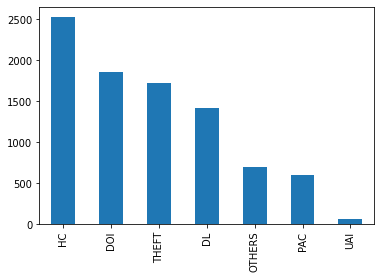

In [ ]:
import matplotlib.pyplot as plt
df1['INCIBE TAXONOMY'].value_counts().plot.bar()
plt.show()

# Split Data for Train and Test


Vectorizar la descripción

In [ ]:
# Maximo numero de palabras usadas
MAX_NB_WORDS = 50000
# Maximo numero de palabras en cada descripción
MAX_SEQUENCE_LENGTH = 300
# La dimensión del embeding
EMBEDDING_DIM = 200

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df1['desp_clean_final'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 13616 unique tokens.


In [ ]:
X = tokenizer.texts_to_sequences(df1['desp_clean_final'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (8901, 300)


In [ ]:
Y = pd.get_dummies(df1['INCIBE TAXONOMY']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (8901, 7)


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.30, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(6230, 300) (6230, 7)
(2671, 300) (2671, 7)


# BERT

In [ ]:
!pip install tensorflow-text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.6 MB 5.3 MB/s 
     |████████████████████████████████| 511.7 MB 6.8 kB/s 
     |████████████████████████████████| 1.6 MB 48.0 MB/s 
     |████████████████████████████████| 5.8 MB 49.8 MB/s 
     |████████████████████████████████| 438 kB 55.5 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Uninst

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import tensorflow as tf
from transformers import BertTokenizer

In [ ]:
df1['int_label']=df1['INCIBE TAXONOMY'].apply(lambda x: 1 if x=='DL' else 2 if x=='DOI' else 3 if x=='HC' else 4 if x=='OTHERS' else 5 if x=='PAC' else 6 if
                                              x=='THEFT' else 7 if x=='UAI' else 0)
df1.sample(5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,desp_clean_final,INCIBE TAXONOMY,int_label
2788,comput tape contain social,DL,1
5410,etrad notifi custom inform may compromis resul...,HC,3
1638,univers remov student social secur number grad...,DOI,2
8525,locat breach inform unauthor accessdisclosur,DOI,2
5135,woman found two bag personnel record backyard ...,HC,3


In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8901 entries, 0 to 8917
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   desp_clean_final  8901 non-null   object
 1   INCIBE TAXONOMY   8901 non-null   object
 2   int_label         8901 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 278.2+ KB


In [ ]:
df1.drop(8900, inplace=True)
df1['int_label'] = df1['int_label'].astype(int)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
df1['int_label'].value_counts()

3    2527
2    1854
6    1727
1    1416
4     702
5     606
7      68
Name: int_label, dtype: int64

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
token = tokenizer.encode_plus(
    df1['desp_clean_final'].iloc[0], 
    max_length=300, 
    truncation=True, 
    padding='max_length', 
    add_special_tokens=True,
    return_tensors='tf'
)

In [ ]:
token.input_ids

<tf.Tensor: shape=(1, 300), dtype=int32, numpy=
array([[  101,  3254, 10224,  1182,  5127,  5053,  1204, 13275,  1199,
         3121,  1306,  1213,   175, 15581,  5082,  7710,  1627,  5871,
         8638,  2661,  4361,  2469,  2218,  8156,   185,  2047, 26465,
        12862,  1934, 14516, 10182,  1197,  1295,  1271,  4134,  3085,
         3300,  1271,  3085,  3300,  1295,  1336,  3254,  1643, 16071,
         1548,  1655,  5385,  1107,  3309, 18312,  1358,  6975,   102,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0, 

In [ ]:
X_input_ids = np.zeros((len(df1), 300))
X_attn_masks = np.zeros((len(df1), 300))

In [ ]:
def generate_training_data(df1, ids, masks, tokenizer):
    for i, text in tqdm(enumerate(df1['desp_clean_final'])):
        tokenized_text = tokenizer.encode_plus(
            text,
            max_length=300, 
            truncation=True, 
            padding='max_length', 
            add_special_tokens=True,
            return_tensors='tf'
        )
        ids[i, :] = tokenized_text.input_ids
        masks[i, :] = tokenized_text.attention_mask
    return ids, masks

In [ ]:
X_input_ids, X_attn_masks = generate_training_data(df1, X_input_ids, X_attn_masks, tokenizer)

0it [00:00, ?it/s]

In [ ]:
labels1 = np.zeros((len(df1), 8))
labels1.shape

(8900, 8)

In [ ]:
labels1[np.arange(len(df1)), df1['int_label'].values] = 1 # one-hot encoded target tensor

In [ ]:
labels1

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

In [ ]:
# creating a data pipeline using tensorflow dataset utility, creates batches of data for easy loading...
dataset = tf.data.Dataset.from_tensor_slices((X_input_ids, X_attn_masks, labels1))
dataset.take(1) # one sample data

<TakeDataset element_spec=(TensorSpec(shape=(300,), dtype=tf.float64, name=None), TensorSpec(shape=(300,), dtype=tf.float64, name=None), TensorSpec(shape=(8,), dtype=tf.float64, name=None))>

In [ ]:
def SentimentDatasetMapFunction(input_ids, attn_masks, labels1):
    return {
        'input_ids': input_ids,
        'attention_mask': attn_masks
    }, labels1

In [ ]:
dataset = dataset.map(SentimentDatasetMapFunction) # converting to required format for tensorflow dataset

In [ ]:
dataset.take(1)

<TakeDataset element_spec=({'input_ids': TensorSpec(shape=(300,), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(300,), dtype=tf.float64, name=None)}, TensorSpec(shape=(8,), dtype=tf.float64, name=None))>

In [ ]:
dataset = dataset.shuffle(10000).batch(4, drop_remainder=True) # batch size, drop any left out tensor

In [ ]:
dataset.take(1)

<TakeDataset element_spec=({'input_ids': TensorSpec(shape=(4, 300), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(4, 300), dtype=tf.float64, name=None)}, TensorSpec(shape=(4, 8), dtype=tf.float64, name=None))>

In [ ]:
p = 0.9
train_size = int((len(df1)//8)*p) # for each 16 batch of data we will have len(df)//16 samples, take 80% of that for train.

In [ ]:
train_size

1000

In [ ]:
train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)

In [ ]:
len(train_dataset)

1000

In [ ]:
test_dataset= dataset.take(len(X_test))

In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
from transformers import TFBertModel

In [ ]:
model = TFBertModel.from_pretrained('bert-base-cased') # bert base model with pretrained weights

Downloading:   0%|          | 0.00/502M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
# defining 2 input layers for input_ids and attn_masks
input_ids = tf.keras.layers.Input(shape=(300,), name='input_ids', dtype='int32')
attn_masks = tf.keras.layers.Input(shape=(300,), name='attention_mask', dtype='int32')

bert_embds = model.bert(input_ids, attention_mask=attn_masks)[1] # 0 -> activation layer (3D), 1 -> pooled output layer (2D)
intermediate_layer = tf.keras.layers.Dense(512, activation='relu', name='intermediate_layer')(bert_embds)
output_layer = tf.keras.layers.Dense(8, activation='softmax', name='output_layer')(intermediate_layer) # softmax -> calcs probs of classes

bert_model = tf.keras.Model(inputs=[input_ids, attn_masks], outputs=output_layer)
bert_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 300)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 300)]        0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 300,                                         

In [ ]:
optim = tf.keras.optimizers.Adam(learning_rate=1e-5, decay=1e-6)
loss_func = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

In [ ]:
bert_model.compile(optimizer=optim, loss=loss_func, metrics=['accuracy',f1_m,precision_m, recall_m])

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
hist = bert_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=5
)

Epoch 1/5
1000/1000 [==============================] - 387s 376ms/step - loss: 0.8304 - accuracy: 0.7095 - f1_m: 0.6540 - precision_m: 0.8091 - recall_m: 0.5813 - val_loss: 0.5215 - val_accuracy: 0.8341 - val_f1_m: 0.8301 - val_precision_m: 0.8772 - val_recall_m: 0.7986
Epoch 2/5
1000/1000 [==============================] - 383s 382ms/step - loss: 0.5005 - accuracy: 0.8363 - f1_m: 0.8326 - precision_m: 0.9023 - recall_m: 0.7875 - val_loss: 0.4338 - val_accuracy: 0.8622 - val_f1_m: 0.8582 - val_precision_m: 0.8976 - val_recall_m: 0.8314
Epoch 3/5
1000/1000 [==============================] - 378s 378ms/step - loss: 0.4237 - accuracy: 0.8687 - f1_m: 0.8659 - precision_m: 0.9083 - recall_m: 0.8365 - val_loss: 0.3490 - val_accuracy: 0.8918 - val_f1_m: 0.8904 - val_precision_m: 0.9383 - val_recall_m: 0.8573
Epoch 4/5
1000/1000 [==============================] - 379s 378ms/step - loss: 0.3472 - accuracy: 0.8928 - f1_m: 0.8899 - precision_m: 0.9278 - recall_m: 0.8637 - val_loss: 0.2945 - val_a

In [ ]:
bert_model.save('model_bert_01')

INFO:tensorflow:Assets written to: model_bert_01/assets


INFO:tensorflow:Assets written to: model_bert_01/assets


In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

def prepare_data(input_text, tokenizer):
    token = tokenizer.encode_plus(
        input_text,
        max_length=300, 
        truncation=True, 
        padding='max_length', 
        add_special_tokens=True,
        return_tensors='tf'
    )
    return {
        'input_ids': tf.cast(token.input_ids, tf.float64),
        'attention_mask': tf.cast(token.attention_mask, tf.float64)
    }

def make_prediction(model, processed_data, classes=['DL', 'DOI', 'HC', 'OTHERS', 'PAC', 'THEFT', 'UAI']):
    probs = model.predict(processed_data)[0]
    return classes[np.argmax(probs)]

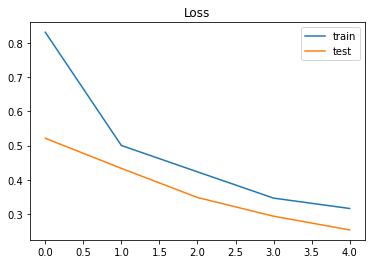

In [ ]:
plt.title('Loss')
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='test')
plt.legend()
plt.show();

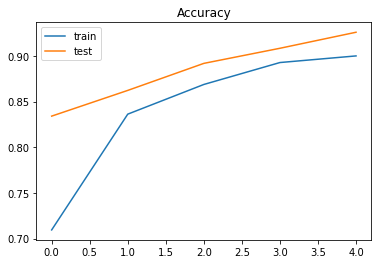

In [ ]:
plt.title('Accuracy')
plt.plot(hist.history['accuracy'], label='train')
plt.plot(hist.history['val_accuracy'], label='test')
plt.legend()
plt.show();

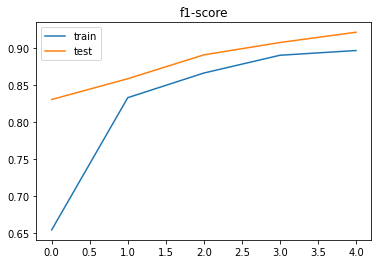

In [ ]:
plt.title('f1-score')
plt.plot(hist.history['f1_m'], label='train')
plt.plot(hist.history['val_f1_m'], label='test')
plt.legend()
plt.show();

In [ ]:
#!tensorboard --logdir ./logs --bind_all

In [ ]:
#%load_ext tensorboard
#%tensorboard --logdir ./logs

# Prueba BERT

In [ ]:
input_text = input('Enter the incident here: ')
processed_data = prepare_data(input_text, tokenizer)
result = make_prediction(bert_model, processed_data=processed_data)
print(f"Predicted Sentiment: {result}")

Enter the incident here: here: hacker abl access name mail address email address date birth usernam password phone number credit card detail custom breach occur detect sunday march 25 manhattan prep remov credit card inform previous associ compromis custom account databas custom account password automat reset custom also encourag chang password use manhattan prep account
Predicted Sentiment: OTHERS
